# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

In [2]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time
import random

In [159]:
def generate(d = 100, m = 1, L = 1000):

    # сгенерируем диагональную матрицу по собственным числам
    if d == 1:
        lambdas = [m]
    if d == 2:
        lambdas = [m, L]
    if d > 2:
        lambdas = np.random.uniform(low=m, high=L, size=(d-2,))
        lambdas = lambdas.tolist() + [m, L]

    A = np.diag(lambdas)
    q, _ = la.qr(np.random.rand(d, d))
    A = q.T @ A @ q
    b = np.random.uniform(low=-L/10, high=L/10, size=(d,))

    return A, b

In [160]:
A = []
b = []
n = 10
for i in range(n):
    A_tmp, b_tmp = generate(d=100, m=1, L=1000)
    A.append(A_tmp)
    b.append(b_tmp)

In [161]:
L = 1000
m = 1
d = 100
gamma_const = 1/(4*L)
x0 = np.random.uniform(low=-L/20, high=L/20, size=(d,))

In [162]:
def f_i(x, i):
    return 1/2 * (x.T @ A[i] @ x - b[i] @ x)

def grad_i(x, i):
    return A[i] @ x - b[i]/2

def f(x):
    g = np.zeros((d,))
    for i in range(n):
        g += f_i(x, i)
    return g/n

def grad(x):
    g = np.zeros((d,))
    for i in range(n):
        g += grad_i(x, i)
    return g/n

In [22]:
def rand_k(g, p):
    l = len(g)
    indices = random.sample(range(l), round(l * p))
    q = np.zeros((l,))
    for i in indices:
        q[i] = g[i]
    return q

def top_k(g, p):
    l = len(g)
    cnt = 0
    num = round(l*p)
    border = sorted([abs(k) for k in g], reverse=True)[num - 1] 
    q = np.zeros((l,))
    for i in range(l):
        if abs(g[i]) >= border:
            q[i] = g[i]
            cnt += 1
        if cnt == num:
            break
    return q

In [164]:
'''
Под количеством передаваемой информации будем понимать количество переданных координат градиента от процессов серверу.
На каждом шаге спуска происходит пересылка n * d * percentile координат. Множитель n не является существенным.
'''
def compression_gd(x0, gamma, Q, percentile=0.20, iters=3000, eps=1e-7):

    x = x0
    x_vals = [x]
    times = [0.]
    errs = [np.linalg.norm(grad(x), ord=2)**2]
    info = 0
    information = [info]
    start = time.time()

    for i in range(1, iters):
        
        step = np.zeros((d,))
        # в этом месте надо было параллелить: каждый из n процессов считает свой grad f_i и скидывает результат в сумматор
        for j in range(n):
            g = grad_i(x, j)
            step += Q(g, percentile)
        x = x - gamma(x, i) * step / n

        x_vals.append(x)
        times.append(time.time() - start)
        err = np.linalg.norm(grad(x), ord=2)**2
        errs.append(err)
        info += d * percentile
        information.append(info)
        if err < eps:
            break

    return x_vals, times, errs, information

In [32]:
def risovach(infos, errs, labels, title):
    plt.figure(figsize=(9, 6))
    for inf, err, lab in zip(infos, errs, labels):
        plt.plot(inf, np.log(err), label=lab)
    plt.xlabel("Число переданной информации")
    plt.ylabel("Логарифм критерия")
    plt.title(title)
    plt.legend(fontsize=12)
    plt.show()

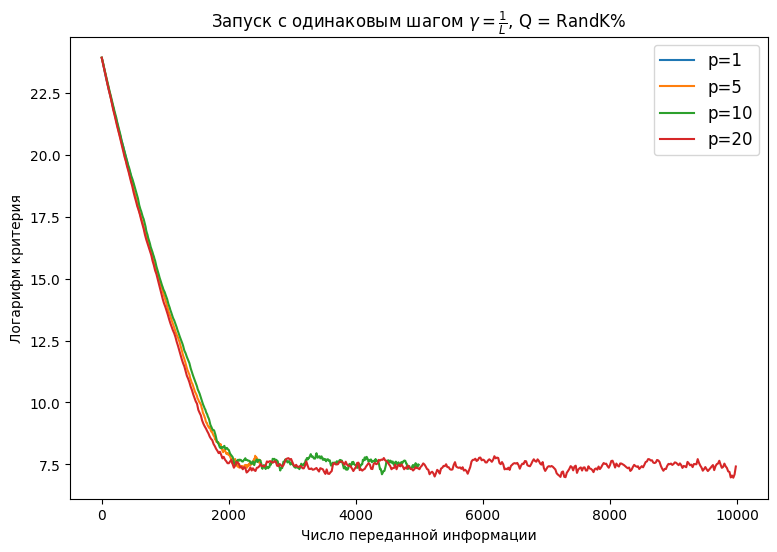

In [166]:
x_1, times_1, errs_1, info_1 = compression_gd(x0=x0, gamma=lambda x, k: 1/L, Q=rand_k, percentile=0.01, iters=500)
x_5, times_5, errs_5, info_5 = compression_gd(x0=x0, gamma=lambda x, k: 1/L, Q=rand_k, percentile=0.05, iters=500)
x_10, times_10, errs_10, info_10 = compression_gd(x0=x0, gamma=lambda x, k: 1/L, Q=rand_k, percentile=0.10, iters=500)
x_20, times_20, errs_20, info_20 = compression_gd(x0=x0, gamma=lambda x, k: 1/L, Q=rand_k, percentile=0.20, iters=500)

risovach(infos=[info_1, info_5, info_10, info_20], 
         errs=[errs_1, errs_5, errs_10, errs_20], 
         labels=['p=1', 'p=5', 'p=10', 'p=20'],
         title=r'Запуск с одинаковым шагом $\gamma = \frac{1}{L}$, Q = RandK%')

Чем меньше шаг, тем медленнее сходимость. В то же время, маленький шаг уменьшает размер ямы, в которой застревает алгоритм. Покажем это.

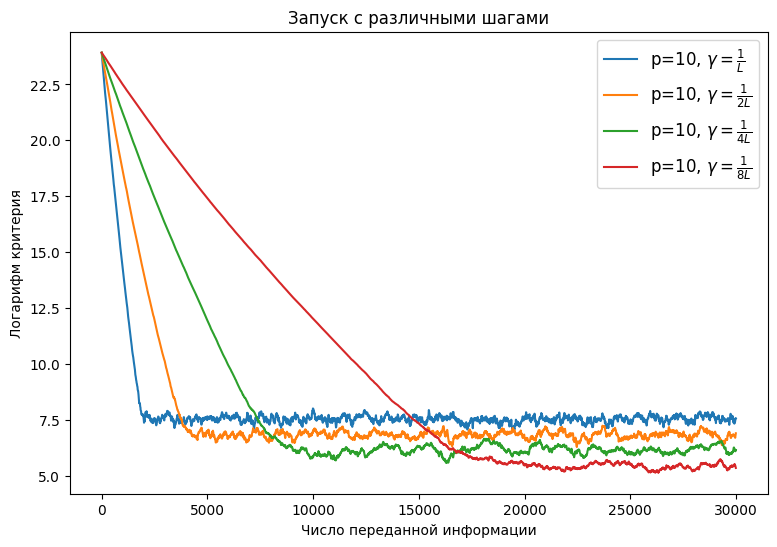

In [168]:
x_1, times_1, errs_1, info_1 = compression_gd(x0=x0, gamma=lambda x, k: 1/L, Q=rand_k, percentile=0.10)
x_5, times_5, errs_5, info_5 = compression_gd(x0=x0, gamma=lambda x, k: 1/(2*L), Q=rand_k, percentile=0.10)
x_10, times_10, errs_10, info_10 = compression_gd(x0=x0, gamma=lambda x, k: 1/(4*L), Q=rand_k, percentile=0.10)
x_20, times_20, errs_20, info_20 = compression_gd(x0=x0, gamma=lambda x, k: 1/(8*L), Q=rand_k, percentile=0.10)

risovach(infos=[info_1, info_5, info_10, info_20], 
         errs=[errs_1, errs_5, errs_10, errs_20],
         labels=[r'p=10, $\gamma = \frac{1}{L}$', r'p=10, $\gamma = \frac{1}{2L}$', 
                 r'p=10, $\gamma = \frac{1}{4L}$', r'p=10, $\gamma = \frac{1}{8L}$'],
         title=r'Запуск с различными шагами')

В качестве очевидного решения проблемы видится уменьшающийся с итерацией шаг.

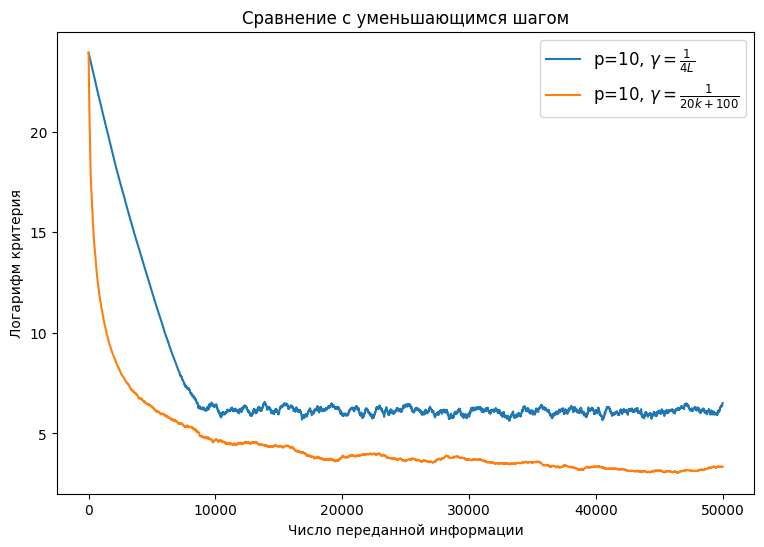

In [179]:
x_1, times_1, errs_1, info_1 = compression_gd(x0=x0, gamma=lambda x, k: 1/(4*L), Q=rand_k, percentile=0.10, iters=5000)
x_2, times_2, errs_2, info_2 = compression_gd(x0=x0, gamma=lambda x, k: 1/(20*k+100), Q=rand_k, percentile=0.10, iters=5000)

risovach(infos=[info_1, info_2], 
         errs=[errs_1, errs_2],
         labels=[r'p=10, $\gamma = \frac{1}{4L}$', r'p=10, $\gamma = \frac{1}{20k+100}$'],
         title=r'Сравнение с уменьшающимся шагом')

Действительно, это помогло повысить точность метода. Сравним теперь операторы TopK% и RandK%.

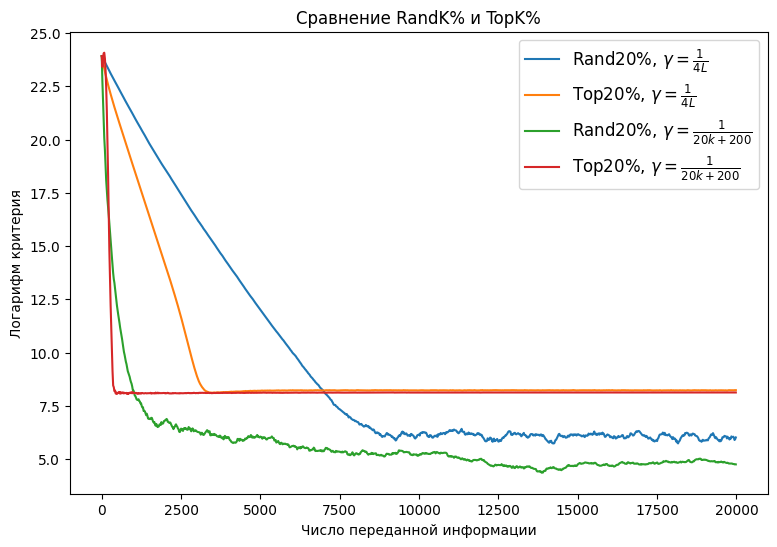

In [194]:
x_1, times_1, errs_1, info_1 = compression_gd(x0=x0, gamma=lambda x, k: 1/(4*L), Q=rand_k, percentile=0.20, iters=1000)
x_2, times_2, errs_2, info_2 = compression_gd(x0=x0, gamma=lambda x, k: 1/(4*L), Q=top_k, percentile=0.20, iters=1000)
x_3, times_3, errs_3, info_3 = compression_gd(x0=x0, gamma=lambda x, k: 1/(20*k+200), Q=rand_k, percentile=0.20, iters=1000)
x_4, times_4, errs_4, info_4 = compression_gd(x0=x0, gamma=lambda x, k: 1/(20*k+200), Q=top_k, percentile=0.20, iters=1000)

risovach(infos=[info_1, info_2, info_3, info_4], 
         errs=[errs_1, errs_2, errs_3, errs_4],
         labels=[r'Rand20%, $\gamma = \frac{1}{4L}$', r'Top20%, $\gamma = \frac{1}{4L}$',
                 r'Rand20%, $\gamma = \frac{1}{20k+200}$', r'Top20%, $\gamma = \frac{1}{20k+200}$'],
         title=r'Сравнение RandK% и TopK%')

Жадный оператор TopK% зарывается в яме быстрее, чем RandK%. 

Скорость обучения с Top выше, чем с Rand, но точность метода при использовании Top быстро выходит на плато. 

Техника уменьшения шага не помогла повысить точность при использовании Top, в отличие от Rand.

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [195]:
def ef_gd(x0, gamma, Q, percentile=0.20, iters=3000, eps=1e-7):

    x = x0
    x_vals = [x]
    times = [0.]
    errs = [np.linalg.norm(grad(x), ord=2)**2]
    info = 0
    information = [info]
    start = time.time()
    e = [np.zeros((d,))] * n

    for i in range(1, iters):
        
        step = np.zeros((d,))
        for j in range(n):
            g = gamma(x, i) * grad_i(x, j)
            g_ = Q(e[j] + g, percentile)
            e[j] = e[j] + g - g_
            step += g_
        x = x - step / n

        x_vals.append(x)
        times.append(time.time() - start)
        err = np.linalg.norm(grad(x), ord=2)**2
        errs.append(err)
        info += d * percentile
        information.append(info)
        if err < eps:
            break

    return x_vals, times, errs, information

Поскольку обычный распределенный спуск с оператором сжатия TopK% не улучшается путем уменьшения шага, а при постоянном шаге скорость сходимости лучше при больших значениях шага, в качестве оптимального значения возьмем $\gamma = \frac{2}{L} = \text{const}$ (при $\gamma = \frac{4}{L}$ метод уже расходится). Определим оптимальные параметры алгоритма с компенсацией ошибки.

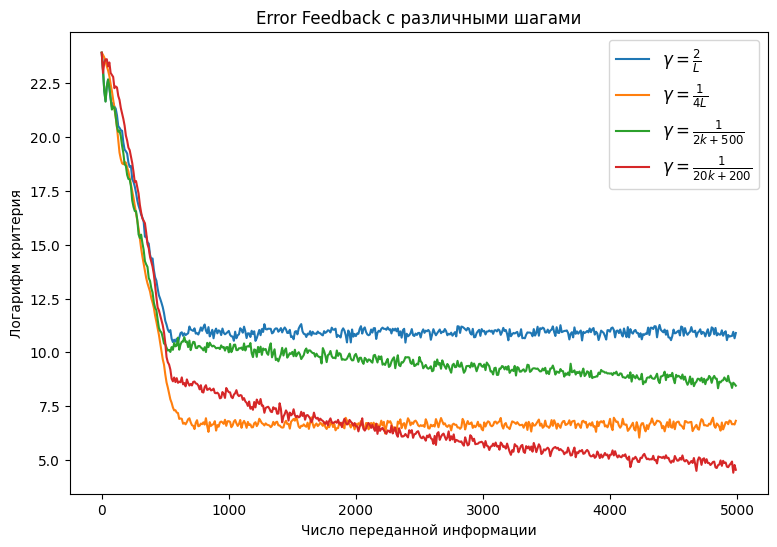

In [212]:
x_1, times_1, errs_1, info_1 = ef_gd(x0=x0, gamma=lambda x, k: 2/L, Q=top_k, percentile=0.10, iters=500)
x_5, times_5, errs_5, info_5 = ef_gd(x0=x0, gamma=lambda x, k: 1/(4*L), Q=top_k, percentile=0.10, iters=500)
x_10, times_10, errs_10, info_10 = ef_gd(x0=x0, gamma=lambda x, k: 1/(2*k+500), Q=top_k, percentile=0.10, iters=500)
x_20, times_20, errs_20, info_20 = ef_gd(x0=x0, gamma=lambda x, k: 1/(20*k+200), Q=top_k, percentile=0.10, iters=500)

risovach(infos=[info_1, info_5, info_10, info_20], 
         errs=[errs_1, errs_5, errs_10, errs_20],
         labels=[r'$\gamma = \frac{2}{L}$', r'$\gamma = \frac{1}{4L}$', 
                 r'$\gamma = \frac{1}{2k+500}$', r'$\gamma = \frac{1}{20k+200}$'],
         title=r'Error Feedback с различными шагами')

Видим, что уменьшающийся шаг существенно улучшает метод. Более резвое уменьшение шага улучшает точность: угол наклона красной прямой больше, чем у зеленой. За оптимальный шаг примем $\gamma = \frac{1}{20k+200}$. Теперь сравним методы.

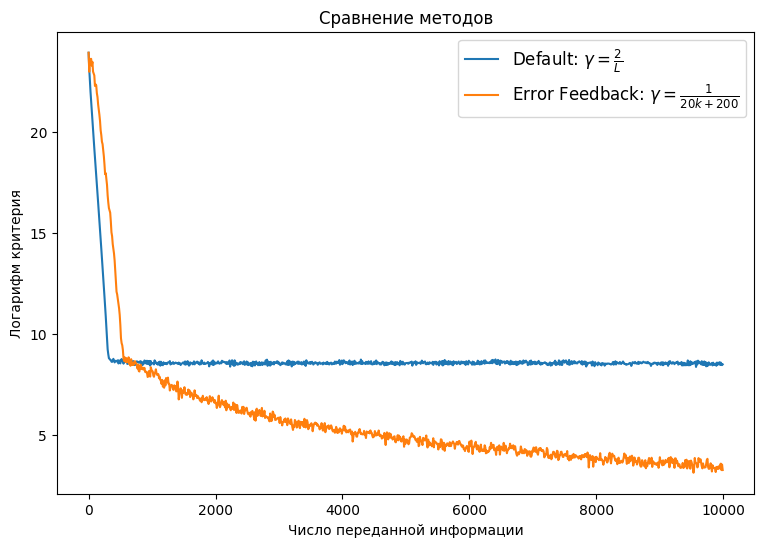

In [214]:
x_1, times_1, errs_1, info_1 = compression_gd(x0=x0, gamma=lambda x, k: 2/L, Q=top_k, percentile=0.10, iters=1000)
x_2, times_2, errs_2, info_2 = ef_gd(x0=x0, gamma=lambda x, k: 1/(20*k + 200), Q=top_k, percentile=0.10, iters=1000)

risovach(infos=[info_1, info_2], 
         errs=[errs_1, errs_2],
         labels=[r'Default: $\gamma = \frac{2}{L}$', r'Error Feedback: $\gamma = \frac{1}{20k+200}$'],
         title=r'Сравнение методов')

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [23]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split 

data = load_svmlight_file("mushrooms.txt")
X, y = data[0].toarray(), data[1]
y = 2 * y - 3
N, d = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8001, shuffle=True)

In [28]:
# перемешиваем данные и делим на 10 равных частей
Z_train = np.concatenate([X_train, y_train.reshape((X_train.shape[0], 1))], axis=1)
np.random.shuffle(Z_train)
X_train, y_train = np.split(Z_train, [-1], axis=1)[0], np.split(Z_train, [-1], axis=1)[1]
n = 10
X_ = np.split(X_train, n)
y_ = np.split(y_train, n)

# значение L взято из прошлого ДЗ
L = 5.25
x0 = np.random.uniform(low=-1, high=1, size=(d,))

In [29]:
from numba import jit

@jit
def f(x, X=X_train, y=y_train):
    Q = 0
    for i in range(X.shape[0]):
        Q += np.log(1 + np.exp(-y[i] * (x.T @ X[i])))
    return Q/X.shape[0]

@jit
def grad(x, X=X_train, y=y_train):
    g = np.zeros(x.shape)
    for i in range(X.shape[0]):
        g += y[i] * X[i] / (1 + np.exp(y[i] * x.T @ X[i]))
    return -g/X.shape[0]

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

In [77]:
def compression_gd(x0, gamma, Q, percentile=0.20, iters=500, eps=1e-20):

    x = x0
    x_vals = [x]
    times = [0.]
    errs = [np.linalg.norm(grad(x), ord=2)**2]
    info = 0
    information = [info]
    start = time.time()

    for i in range(1, iters):
        
        step = np.zeros((d,))
        for j in range(n):
            g = grad(x, X=X_[j], y=y_[j])
            step += Q(g, percentile)
        x = x - gamma(x, i) * step / n

        x_vals.append(x)
        times.append(time.time() - start)
        err = np.linalg.norm(grad(x), ord=2)**2
        errs.append(err)
        info += d * percentile
        information.append(info)
        if err < eps:
            break

    return x_vals, times, errs, information

def ef_gd(x0, gamma, Q, percentile=0.20, iters=500, eps=1e-20):

    x = x0
    x_vals = [x]
    times = [0.]
    errs = [np.linalg.norm(grad(x), ord=2)**2]
    info = 0
    information = [info]
    start = time.time()
    e = [np.zeros((d,))] * n

    for i in range(1, iters):
        
        step = np.zeros((d,))
        for j in range(n):
            g = gamma(x, i) * grad(x, X=X_[j], y=y_[j])
            g_ = Q(e[j] + g, percentile)
            e[j] = e[j] + g - g_
            step += g_
        x = x - step / n

        x_vals.append(x)
        times.append(time.time() - start)
        err = np.linalg.norm(grad(x), ord=2)**2
        errs.append(err)
        info += d * percentile
        information.append(info)
        if err < eps:
            break

    return x_vals, times, errs, information

def diana(x0, gamma, Q, percentile=0.20, alpha=0.20, iters=500, eps=1e-20):

    x = x0
    x_vals = [x]
    times = [0.]
    errs = [np.linalg.norm(grad(x), ord=2)**2]
    info = 0
    information = [info]
    start = time.time()

    delta = [np.zeros((d,))] * n
    h = [grad(x, X=X_[j], y=y_[j]) for j in range(n)]

    for i in range(1, iters):
        
        step = np.zeros((d,))
        for j in range(n):
            delta[j] = Q(grad(x, X=X_[j], y=y_[j]) - h[j], percentile)
            step += h[j] + delta[j]
            h[j] = h[j] + alpha * delta[j]
        x = x - gamma(x, i) * step / n

        x_vals.append(x)
        times.append(time.time() - start)
        err = np.linalg.norm(grad(x), ord=2)**2
        errs.append(err)
        info += d * percentile
        information.append(info)
        if err < eps:
            break

    return x_vals, times, errs, information

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

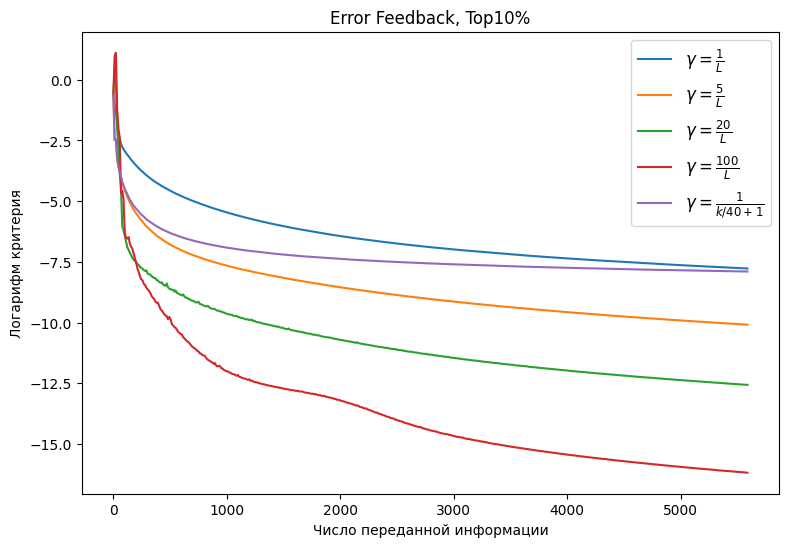

In [92]:
iters = 500
x_1, times_1, errs_1, info_1 = ef_gd(x0=x0, gamma=lambda x, k: 1/L, Q=top_k, percentile=0.10, iters=iters)
x_5, times_5, errs_5, info_5 = ef_gd(x0=x0, gamma=lambda x, k: 5/L, Q=top_k, percentile=0.10, iters=iters)
x_10, times_10, errs_10, info_10 = ef_gd(x0=x0, gamma=lambda x, k: 20/L, Q=top_k, percentile=0.10, iters=iters)
x_15, times_15, errs_15, info_15 = ef_gd(x0=x0, gamma=lambda x, k: 100/L, Q=top_k, percentile=0.10, iters=iters)
x_20, times_20, errs_20, info_20 = ef_gd(x0=x0, gamma=lambda x, k: 1/(k/40+1), Q=top_k, percentile=0.10, iters=iters)

risovach(infos=[info_1, info_5, info_10, info_15, info_20], 
         errs=[errs_1, errs_5, errs_10, errs_15, errs_20],
         labels=[r'$\gamma = \frac{1}{L}$', r'$\gamma = \frac{5}{L}$', 
                 r'$\gamma = \frac{20}{L}$', r'$\gamma = \frac{100}{L}$',
                 r'$\gamma = \frac{1}{k/40+1}$'],
         title=r'Error Feedback, Top10%')

# уменьшение шага не улучшает точность метода. да и в целом замечено, что в этой задаче в подобном нужды нет
# среди постоянных победил 100/L 
# при большем шаге наблюдается  сильное расхождение на первых итерациях

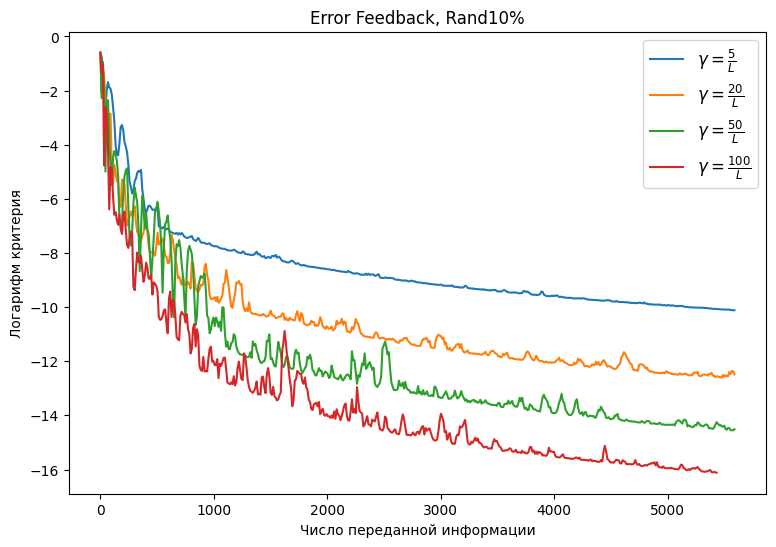

In [56]:
iters = 500
x_1, times_1, errs_1, info_1 = ef_gd(x0=x0, gamma=lambda x, k: 5/L, Q= rand_k, percentile=0.10, iters=iters)
x_5, times_5, errs_5, info_5 = ef_gd(x0=x0, gamma=lambda x, k: 20/L, Q=rand_k, percentile=0.10, iters=iters)
x_10, times_10, errs_10, info_10 = ef_gd(x0=x0, gamma=lambda x, k: 50/L, Q=rand_k, percentile=0.10, iters=iters)
x_20, times_20, errs_20, info_20 = ef_gd(x0=x0, gamma=lambda x, k: 100/L, Q=rand_k, percentile=0.10, iters=iters)

risovach(infos=[info_1, info_5, info_10, info_20], 
         errs=[errs_1, errs_5, errs_10, errs_20],
         labels=[r'$\gamma = \frac{5}{L}$', r'$\gamma = \frac{20}{L}$', 
                 r'$\gamma = \frac{50}{L}$', r'$\gamma = \frac{100}{L}$'],
         title=r'Error Feedback, Rand10%')

# оптимальный -- 100/L

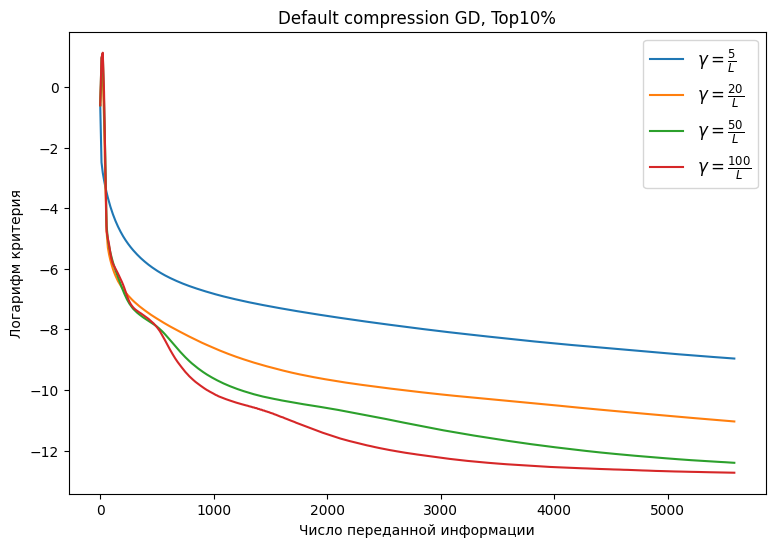

In [73]:
iters = 500
x_1, times_1, errs_1, info_1 = compression_gd(x0=x0, gamma=lambda x, k: 5/L, Q= top_k, percentile=0.10, iters=iters)
x_2, times_2, errs_2, info_2 = compression_gd(x0=x0, gamma=lambda x, k: 20/L, Q=top_k, percentile=0.10, iters=iters)
x_3, times_3, errs_3, info_3 = compression_gd(x0=x0, gamma=lambda x, k: 50/L, Q=top_k, percentile=0.10, iters=iters)
x_4, times_4, errs_4, info_4 = compression_gd(x0=x0, gamma=lambda x, k: 100/L, Q=top_k, percentile=0.10, iters=iters)

risovach(infos=[info_1, info_2, info_3, info_4], 
         errs=[errs_1, errs_2, errs_3, errs_4],
         labels=[r'$\gamma = \frac{5}{L}$', r'$\gamma = \frac{20}{L}$', 
                 r'$\gamma = \frac{50}{L}$', r'$\gamma = \frac{100}{L}$'],
         title=r'Default compression GD, Top10%')

# при большом номере итерации скорость сходимости метода страдает при больших значениях шага
# в качестве оптимального значения возьму 50/L

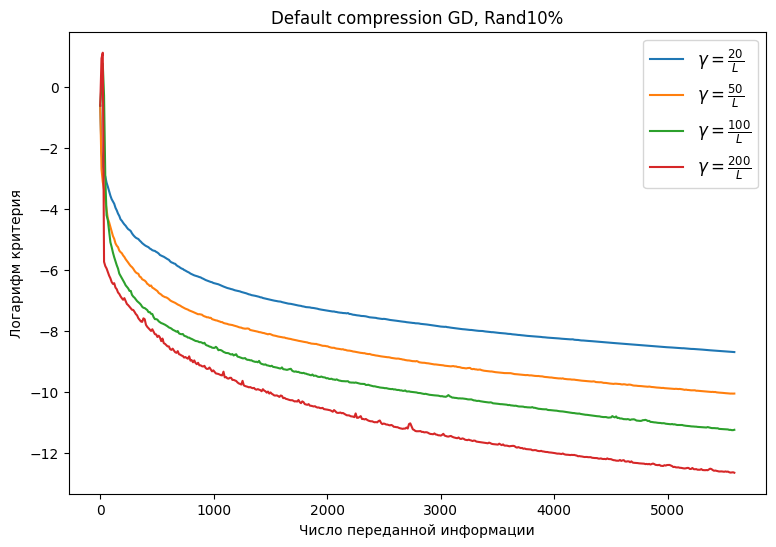

In [74]:
iters = 500
x_1, times_1, errs_1, info_1 = compression_gd(x0=x0, gamma=lambda x, k: 20/L, Q= rand_k, percentile=0.10, iters=iters)
x_2, times_2, errs_2, info_2 = compression_gd(x0=x0, gamma=lambda x, k: 50/L, Q=rand_k, percentile=0.10, iters=iters)
x_3, times_3, errs_3, info_3 = compression_gd(x0=x0, gamma=lambda x, k: 100/L, Q=rand_k, percentile=0.10, iters=iters)
x_4, times_4, errs_4, info_4 = compression_gd(x0=x0, gamma=lambda x, k: 200/L, Q=rand_k, percentile=0.10, iters=iters)

risovach(infos=[info_1, info_2, info_3, info_4], 
         errs=[errs_1, errs_2, errs_3, errs_4],
         labels=[r'$\gamma = \frac{20}{L}$', r'$\gamma = \frac{50}{L}$', 
                 r'$\gamma = \frac{100}{L}$', r'$\gamma = \frac{200}{L}$'],
         title=r'Default compression GD, Rand10%')

# оператор Rand лучше себя чувствует с большим шагом
# оптимальное значение -- 200/L

Разберемся с DIANA. Помимо шага в этом методе можно подбирать $\alpha$. Сильно умничать не буду: в статье говорят брать $\alpha \leq \frac{1}{w+1}$, что в нашей задаче означает $\alpha \approx \text{percentile}$. В начале определим оптимальный шаг, а потом пошевелим $\alpha$ и посмотрим, что произойдет.

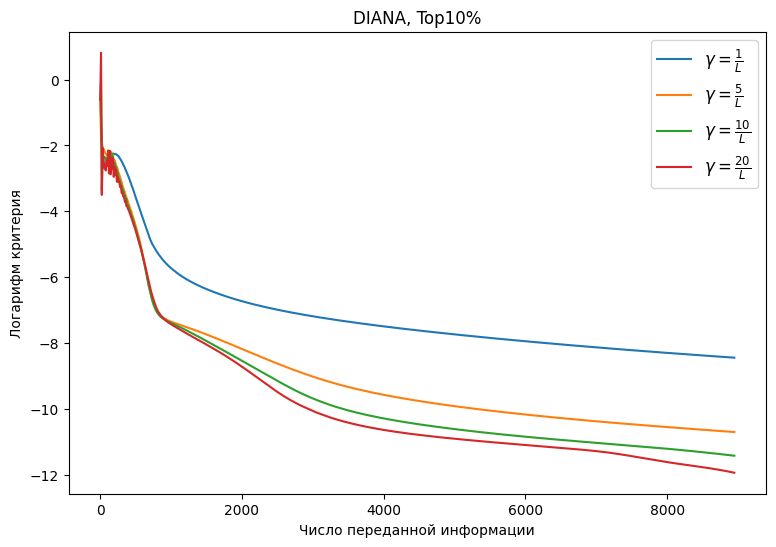

In [88]:
iters = 800
x_1, times_1, errs_1, info_1 = diana(x0=x0, gamma=lambda x, k: 1/L, Q=top_k, percentile=0.10, alpha=0.10, iters=iters)
x_2, times_2, errs_2, info_2 = diana(x0=x0, gamma=lambda x, k: 5/L, Q=top_k, percentile=0.10, alpha=0.10, iters=iters)
x_3, times_3, errs_3, info_3 = diana(x0=x0, gamma=lambda x, k: 10/L, Q=top_k, percentile=0.10, alpha=0.10, iters=iters)
x_4, times_4, errs_4, info_4 = diana(x0=x0, gamma=lambda x, k: 20/L, Q=top_k, percentile=0.10, alpha=0.10, iters=iters)

risovach(infos=[info_1, info_2, info_3, info_4], 
         errs=[errs_1, errs_2, errs_3, errs_4],
         labels=[r'$\gamma = \frac{1}{L}$', r'$\gamma = \frac{5}{L}$', 
                 r'$\gamma = \frac{10}{L}$', r'$\gamma = \frac{20}{L}$'],
         title=r'DIANA, Top10%')

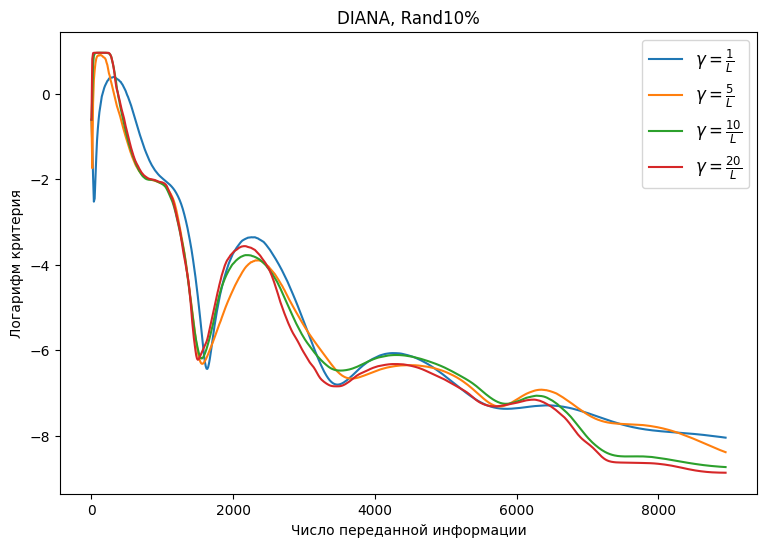

In [89]:
iters = 800
x_1, times_1, errs_1, info_1 = diana(x0=x0, gamma=lambda x, k: 1/L, Q=rand_k, percentile=0.10, alpha=0.10, iters=iters)
x_2, times_2, errs_2, info_2 = diana(x0=x0, gamma=lambda x, k: 5/L, Q=rand_k, percentile=0.10, alpha=0.10, iters=iters)
x_3, times_3, errs_3, info_3 = diana(x0=x0, gamma=lambda x, k: 10/L, Q=rand_k, percentile=0.10, alpha=0.10, iters=iters)
x_4, times_4, errs_4, info_4 = diana(x0=x0, gamma=lambda x, k: 20/L, Q=rand_k, percentile=0.10, alpha=0.10, iters=iters)

risovach(infos=[info_1, info_2, info_3, info_4], 
         errs=[errs_1, errs_2, errs_3, errs_4],
         labels=[r'$\gamma = \frac{1}{L}$', r'$\gamma = \frac{5}{L}$', 
                 r'$\gamma = \frac{10}{L}$', r'$\gamma = \frac{20}{L}$'],
         title=r'DIANA, Rand10%')

При шагах 10/L и 20/L поведение метода в обоих случаях отличается слабо, дальнейшее увеличение шага тоже не дает ничего интересного.

Примем за оптимум 20/L в обоих случаях. Теперь поварьируем $\alpha$.

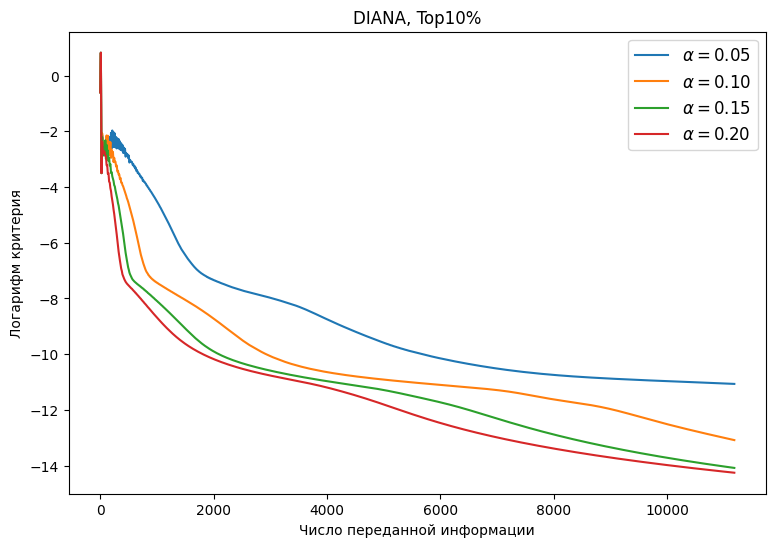

In [91]:
iters = 1000
x_1, times_1, errs_1, info_1 = diana(x0=x0, gamma=lambda x, k: 20/L, Q=top_k, percentile=0.10, alpha=0.05, iters=iters)
x_2, times_2, errs_2, info_2 = diana(x0=x0, gamma=lambda x, k: 20/L, Q=top_k, percentile=0.10, alpha=0.10, iters=iters)
x_3, times_3, errs_3, info_3 = diana(x0=x0, gamma=lambda x, k: 20/L, Q=top_k, percentile=0.10, alpha=0.15, iters=iters)
x_4, times_4, errs_4, info_4 = diana(x0=x0, gamma=lambda x, k: 20/L, Q=top_k, percentile=0.10, alpha=0.20, iters=iters)

risovach(infos=[info_1, info_2, info_3, info_4], 
         errs=[errs_1, errs_2, errs_3, errs_4],
         labels=[r'$\alpha = 0.05$', r'$\alpha = 0.10$', 
                 r'$\alpha = 0.15$', r'$\alpha = 0.20$'],
         title=r'DIANA, Top10%')

Как и с шагом, увеличение $\alpha$ приносит свои плоды лишь до поры до времени. Оптимум примем равным 0.2, что лишь вдвое отличается от теоретической оценки. 

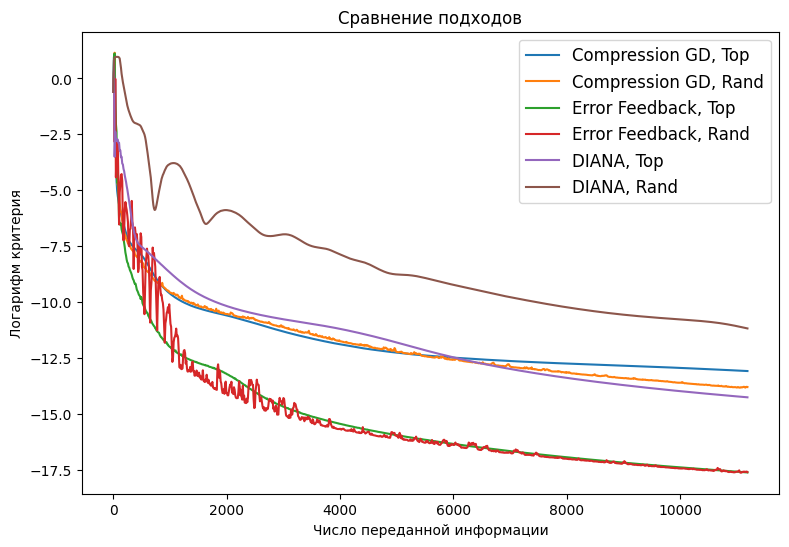

In [93]:
iters = 1000
x_1, times_1, errs_1, info_1 = compression_gd(x0=x0, gamma=lambda x, k: 50/L, Q=top_k, percentile=0.10, iters=iters)
x_2, times_2, errs_2, info_2 = compression_gd(x0=x0, gamma=lambda x, k: 200/L, Q=rand_k, percentile=0.10, iters=iters)
x_3, times_3, errs_3, info_3 = ef_gd(x0=x0, gamma=lambda x, k: 100/L, Q=top_k, percentile=0.10, iters=iters)
x_4, times_4, errs_4, info_4 = ef_gd(x0=x0, gamma=lambda x, k: 100/L, Q=rand_k, percentile=0.10, iters=iters)
x_5, times_5, errs_5, info_5 = diana(x0=x0, gamma=lambda x, k: 20/L, Q=top_k, percentile=0.10, alpha=0.20, iters=iters)
x_6, times_6, errs_6, info_6 = diana(x0=x0, gamma=lambda x, k: 20/L, Q=rand_k, percentile=0.10, alpha=0.20, iters=iters)

risovach(infos=[info_1, info_2, info_3, info_4, info_5, info_6], 
         errs=[errs_1, errs_2, errs_3, errs_4, errs_5, errs_6],
         labels=['Compression GD, Top', 'Compression GD, Rand', 
                 'Error Feedback, Top', 'Error Feedback, Rand',
                 'DIANA, Top', 'DIANA, Rand'],
         title='Сравнение подходов')

Выводы:

1. Техника компенсация ошибки является очень крутой надстройкой над обычным распределенным спуском с сжатием. В данном эксперименте этот метод показал наилучшие результаты.

2. Метод DIANA силен лишь при использовании оператора Top. Он обходит стандартный распределенный спуск, но проигрывает EF. Однако заметим, что после выхода на прямую фиолетовый график идет почти параллельно зеленому и красному, т.е. у них одна скорость сходимости. Возможно, при других настройках метода или на других задачах этот результат будет отличаться.

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [ ]:
#ответ

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [ ]:
#ответ